Preview of dataset:
   Activity ID          Activity Date      Activity Name Activity Type  \
0   2929442069  23 Mar 2023, 03:23:30  Cricket Session 1       Cricket   
1   2929442070  03 Aug 2022, 03:23:30  Cricket Session 2       Cricket   
2   2929442071  29 Oct 2022, 03:23:30  Cricket Session 3       Cricket   
3   2929442072  19 Oct 2023, 03:23:30  Cricket Session 4       Cricket   
4   2929442073  02 Nov 2023, 03:23:30  Cricket Session 5       Cricket   

   Elapsed Time  Distance  Max Heart Rate  Relative Effort  Commute  \
0          6482  6.124643           140.0             18.0    False   
1          4679  3.877109           165.0             19.0    False   
2          4528  9.762030           174.0             10.0     True   
3          7061  7.304651           148.0             19.0    False   
4          6441  3.112718           168.0             15.0    False   

                       Filename  ...  Maximum Power 5.0min  \
0  activities/3028135094.csv.gz  ...          

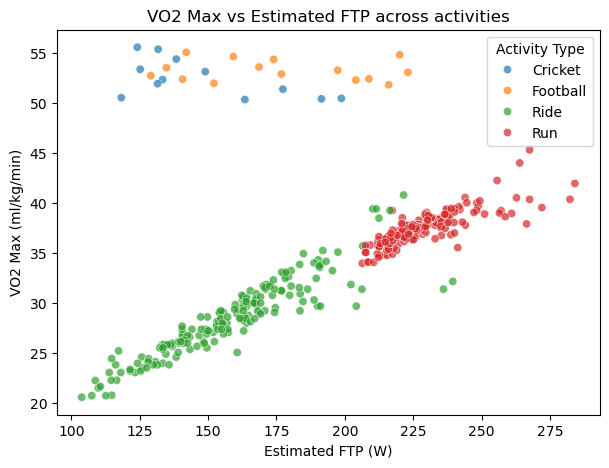

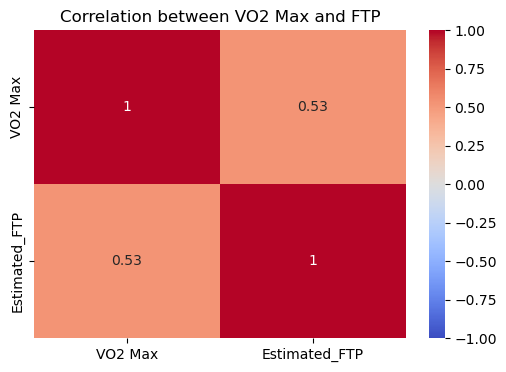


Model Performance:
R² Score: 0.22
RMSE: 7.089


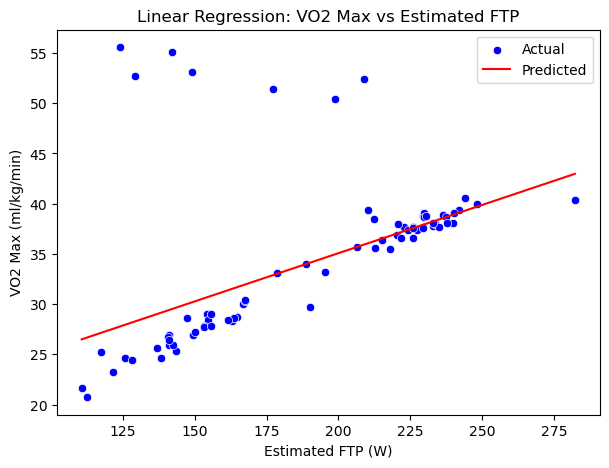

In [5]:
# --------------------------------------------
# ReflexionPro Data Analysis Team - Project 3
# Dataset: simu_vo2_activities_with_ftp.csv
# Task: VO2 Max prediction & exploratory analysis
# --------------------------------------------

# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# 2. Load dataset
file_path = "simu_vo2_activities_with_ftp.csv"
data = pd.read_csv(file_path)

print("Preview of dataset:")
print(data.head())

print("\nAvailable columns:")
print(data.columns.tolist())

# 3. Basic cleaning
# Drop rows with missing VO2 Max or Estimated_FTP values
data = data.dropna(subset=["VO2 Max", "Estimated_FTP"])

# Remove extreme outliers for VO2 Max (using IQR method)
q1 = data["VO2 Max"].quantile(0.25)
q3 = data["VO2 Max"].quantile(0.75)
iqr = q3 - q1
lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
data = data[(data["VO2 Max"] >= lower) & (data["VO2 Max"] <= upper)]

print(f"\nDataset after cleaning: {data.shape[0]} rows remain")

# 4. Exploratory analysis
plt.figure(figsize=(7,5))
sns.scatterplot(x="Estimated_FTP", y="VO2 Max", hue="Activity Type", data=data, alpha=0.7)
plt.title("VO2 Max vs Estimated FTP across activities")
plt.xlabel("Estimated FTP (W)")
plt.ylabel("VO2 Max (ml/kg/min)")
plt.legend(title="Activity Type")
plt.show()

# Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(data[["VO2 Max", "Estimated_FTP"]].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between VO2 Max and FTP")
plt.show()

# 5. Predictive modeling (Linear Regression)
X = data[["Estimated_FTP"]]
y = data["VO2 Max"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nModel Performance:")
print("R² Score:", round(r2_score(y_test, y_pred), 3))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 3))

# 6. Visualization of regression fit
plt.figure(figsize=(7,5))
sns.scatterplot(x=X_test["Estimated_FTP"], y=y_test, color="blue", label="Actual")
sns.lineplot(x=X_test["Estimated_FTP"], y=y_pred, color="red", label="Predicted")
plt.title("Linear Regression: VO2 Max vs Estimated FTP")
plt.xlabel("Estimated FTP (W)")
plt.ylabel("VO2 Max (ml/kg/min)")
plt.legend()
plt.show()


Data shape after cleaning: X=(372, 1), y=(372,)

=== Cross-Validated Performance (sorted by Mean R2) ===
             Model  Mean R2  Mean RMSE                                                               Best Params
 Linear Regression 0.264913   6.245691                                                                        {}
Polynomial (deg=2) 0.263155   6.252014                                                                        {}
Polynomial (deg=3) 0.260721   6.263127                                                                        {}
         SVR (rbf) 0.253093   6.293899                                         {'svr__C': 1, 'svr__gamma': 0.01}
      SVR (linear) 0.207272   6.473297                                                           {'svr__C': 0.1}
     Random Forest 0.095921   6.917775 {'rf__max_depth': 5, 'rf__min_samples_split': 5, 'rf__n_estimators': 400}


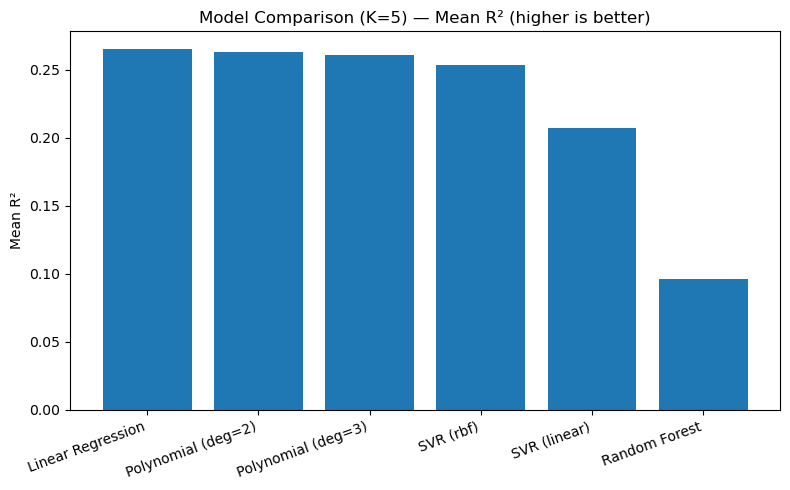

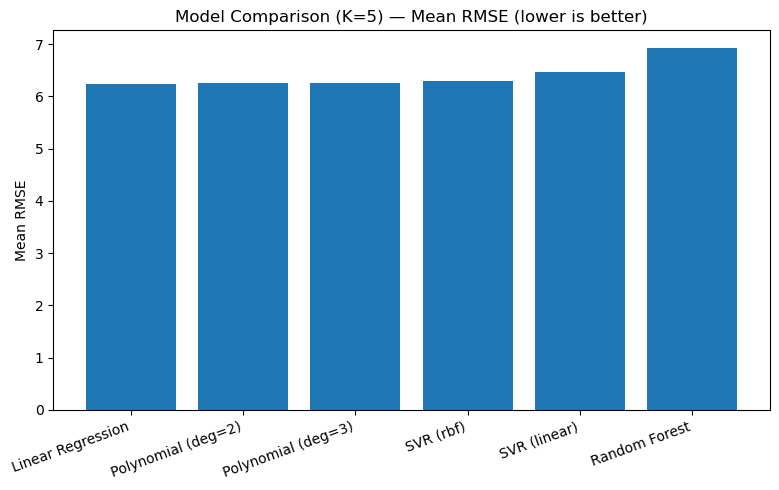


Best model by Mean R²: Linear Regression


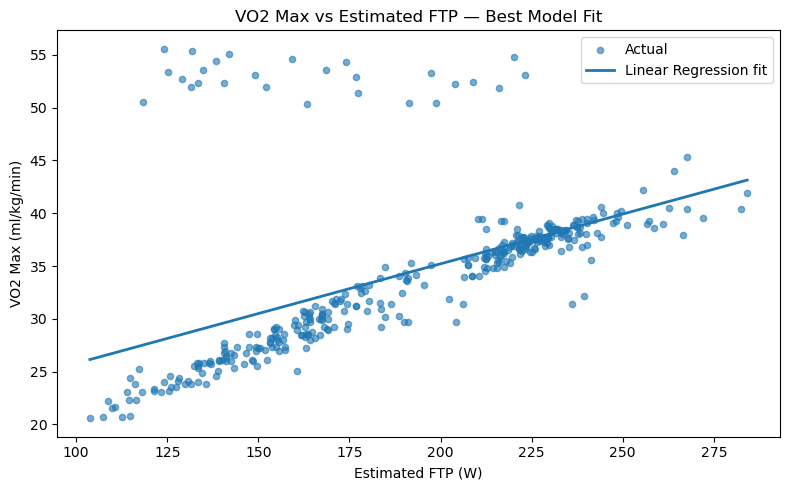

In [7]:
# -----------------------------------------------------------
# ReflexionPro — VO2 Max Modeling (single-feature: Estimated_FTP)
# Models: Linear, Polynomial (deg 2/3), SVR (linear/RBF), Random Forest
# CV: K-Fold; Metrics: R2 (↑ better), RMSE (↓ better)
# Output: Ranked table + bar chart (best → worst by mean R2)
# -----------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error

# -----------------------------
# 1) Load & light cleaning
# -----------------------------
df = pd.read_csv("simu_vo2_activities_with_ftp.csv")

# Keep only the columns we need; drop rows with missing/invalid values
needed_cols = ["VO2 Max", "Estimated_FTP"]
df = df[needed_cols].copy()
df = df.dropna(subset=needed_cols)

# Ensure numeric (coerce just in case)
df["VO2 Max"] = pd.to_numeric(df["VO2 Max"], errors="coerce")
df["Estimated_FTP"] = pd.to_numeric(df["Estimated_FTP"], errors="coerce")
df = df.dropna(subset=needed_cols)

# Optional: remove extreme outliers in target (simple IQR)
q1, q3 = df["VO2 Max"].quantile([0.25, 0.75])
iqr = q3 - q1
lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
df = df[(df["VO2 Max"] >= lo) & (df["VO2 Max"] <= hi)]

X = df[["Estimated_FTP"]].values
y = df["VO2 Max"].values

print(f"Data shape after cleaning: X={X.shape}, y={y.shape}")

# -----------------------------
# 2) Define models & grids
# -----------------------------
# We’ll standardize where it helps (SVR, polynomial). For plain Linear, scaling is optional.
models = {
    "Linear Regression": Pipeline([
        ("lin", LinearRegression())
    ]),

    "Polynomial (deg=2)": Pipeline([
        ("scale", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin", LinearRegression())
    ]),

    "Polynomial (deg=3)": Pipeline([
        ("scale", StandardScaler()),
        ("poly", PolynomialFeatures(degree=3, include_bias=False)),
        ("lin", LinearRegression())
    ]),

    "SVR (linear)": Pipeline([
        ("scale", StandardScaler()),
        ("svr", SVR(kernel="linear"))
    ]),

    "SVR (rbf)": Pipeline([
        ("scale", StandardScaler()),
        ("svr", SVR(kernel="rbf"))
    ]),

    "Random Forest": Pipeline([
        ("rf", RandomForestRegressor(random_state=42))
    ]),
}

# Light hyperparameter grids (kept tight so they run quickly)
param_grids = {
    "Linear Regression": {},  # no params

    "Polynomial (deg=2)": {
        # Nothing to tune here unless you want regularization; degree fixed by pipeline
    },

    "Polynomial (deg=3)": {
        # Same as above
    },

    "SVR (linear)": {
        "svr__C": [0.1, 1, 10]
    },

    "SVR (rbf)": {
        "svr__C": [0.1, 1, 10],
        "svr__gamma": ["scale", 0.1, 0.01]
    },

    "Random Forest": {
        "rf__n_estimators": [200, 400],
        "rf__max_depth": [None, 5, 10],
        "rf__min_samples_split": [2, 5]
    }
}

# -----------------------------
# 3) Cross-validation setup
# -----------------------------
k = 5  # K-Fold
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# scoring: R2 and RMSE (use negative RMSE so higher is better internally, then flip the sign)
def rmse(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {
    "r2": make_scorer(r2_score),
    "neg_rmse": make_scorer(rmse, greater_is_better=False)
}

# -----------------------------
# 4) Evaluate all models
# -----------------------------
results = []

for name, pipe in models.items():
    grid = param_grids.get(name, {})
    if grid:
        # Grid search inside CV to pick best hyperparams (still evaluated via nested cv via refit on inner splits)
        gs = GridSearchCV(pipe, grid, scoring="r2", cv=cv, n_jobs=-1, refit=True)
        gs.fit(X, y)
        best_pipe = gs.best_estimator_
        # Evaluate best_pipe via cross_validate
        cv_out = cross_validate(best_pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
        mean_r2 = cv_out["test_r2"].mean()
        mean_rmse = -cv_out["test_neg_rmse"].mean()
        results.append({
            "Model": name,
            "Best Params": gs.best_params_,
            "Mean R2": mean_r2,
            "Mean RMSE": mean_rmse
        })
    else:
        # No gridsearch needed
        cv_out = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
        mean_r2 = cv_out["test_r2"].mean()
        mean_rmse = -cv_out["test_neg_rmse"].mean()
        results.append({
            "Model": name,
            "Best Params": {},
            "Mean R2": mean_r2,
            "Mean RMSE": mean_rmse
        })

# Put results in a DataFrame and rank
res_df = pd.DataFrame(results)
res_df = res_df.sort_values(by="Mean R2", ascending=False).reset_index(drop=True)

print("\n=== Cross-Validated Performance (sorted by Mean R2) ===")
print(res_df[["Model", "Mean R2", "Mean RMSE", "Best Params"]].to_string(index=False))

# -----------------------------
# 5) Plot comparison (best → worst)
# -----------------------------
plt.figure(figsize=(8, 5))
plt.bar(res_df["Model"], res_df["Mean R2"])
plt.title(f"Model Comparison (K={k}) — Mean R² (higher is better)")
plt.ylabel("Mean R²")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# Optional: also show RMSE comparison
plt.figure(figsize=(8, 5))
plt.bar(res_df["Model"], res_df["Mean RMSE"])
plt.title(f"Model Comparison (K={k}) — Mean RMSE (lower is better)")
plt.ylabel("Mean RMSE")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# -----------------------------
# 6) Fit best model on full data and show a quick fit plot
# -----------------------------
best_model_name = res_df.iloc[0]["Model"]
print(f"\nBest model by Mean R²: {best_model_name}")

# Rebuild best pipeline with best params and fit on all data
best_pipe = models[best_model_name]
best_params = res_df.iloc[0]["Best Params"]
if best_params:
    # Need to rebuild with params; easiest is set_params then fit
    best_pipe.set_params(**best_params)

best_pipe.fit(X, y)

# Quick visualization: predictions vs FTP (for 1D feature this is handy)
# Create a smooth grid of FTP values
x_grid = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
y_pred_grid = best_pipe.predict(x_grid)

plt.figure(figsize=(8, 5))
plt.scatter(X, y, s=20, alpha=0.6, label="Actual")
plt.plot(x_grid, y_pred_grid, linewidth=2, label=f"{best_model_name} fit")
plt.title("VO2 Max vs Estimated FTP — Best Model Fit")
plt.xlabel("Estimated FTP (W)")
plt.ylabel("VO2 Max (ml/kg/min)")
plt.legend()
plt.tight_layout()
plt.show()
